# Dataset visualization
This notebook will help you visualize the data distribution.
## Visualize training curves

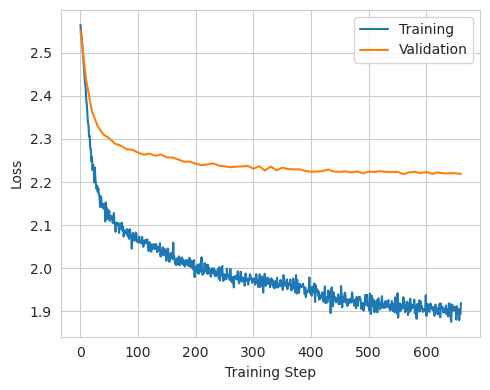

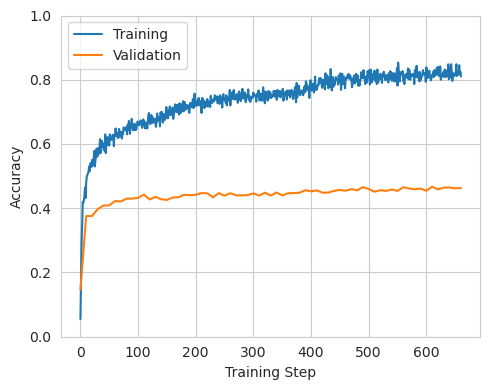

In [29]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
import os

# Load the event file
event_path = "/home/xavier/Documents/dataset/Welch/classification-v2024/classification_models/240430-001/events.out.tfevents.1714504231.xavier-desktop.6817.0"
OUT_DIR = "/home/xavier/PycharmProjects/imgs_for_publication/sup_figure1"
os.makedirs(OUT_DIR, exist_ok=True)
ea = EventAccumulator(event_path)
ea.Reload()

# Plot Loss curves
plt.figure(figsize=(5, 4))
for tag, label, color in zip(['Loss/train', 'Balanced_Loss/validation'], ["Training", "Validation"],
                             ['blue', 'orange']):
    events = ea.Scalars(tag)
    steps = [e.step for e in events]
    values = [e.value for e in events]
    plt.plot(steps, values, label=label)

plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()

# Save as vector graphic
plt.savefig(os.path.join(OUT_DIR, "loss_curve.pdf"), format="pdf", dpi=300)

# Plot Loss curves
plt.figure(figsize=(5, 4))
for tag, label, color in zip(['Accuracy/train', 'Balanced_Accuracy/validation'], ["Training", "Validation"],
                             ['blue', 'orange']):
    events = ea.Scalars(tag)
    steps = [e.step for e in events]
    values = [e.value for e in events]
    plt.plot(steps, values, label=label)

plt.xlabel("Training Step")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()

# Save as vector graphic
plt.savefig(os.path.join(OUT_DIR, "accuracy_curve.pdf"), format="pdf", dpi=300)

## Visualize randomly sampled images

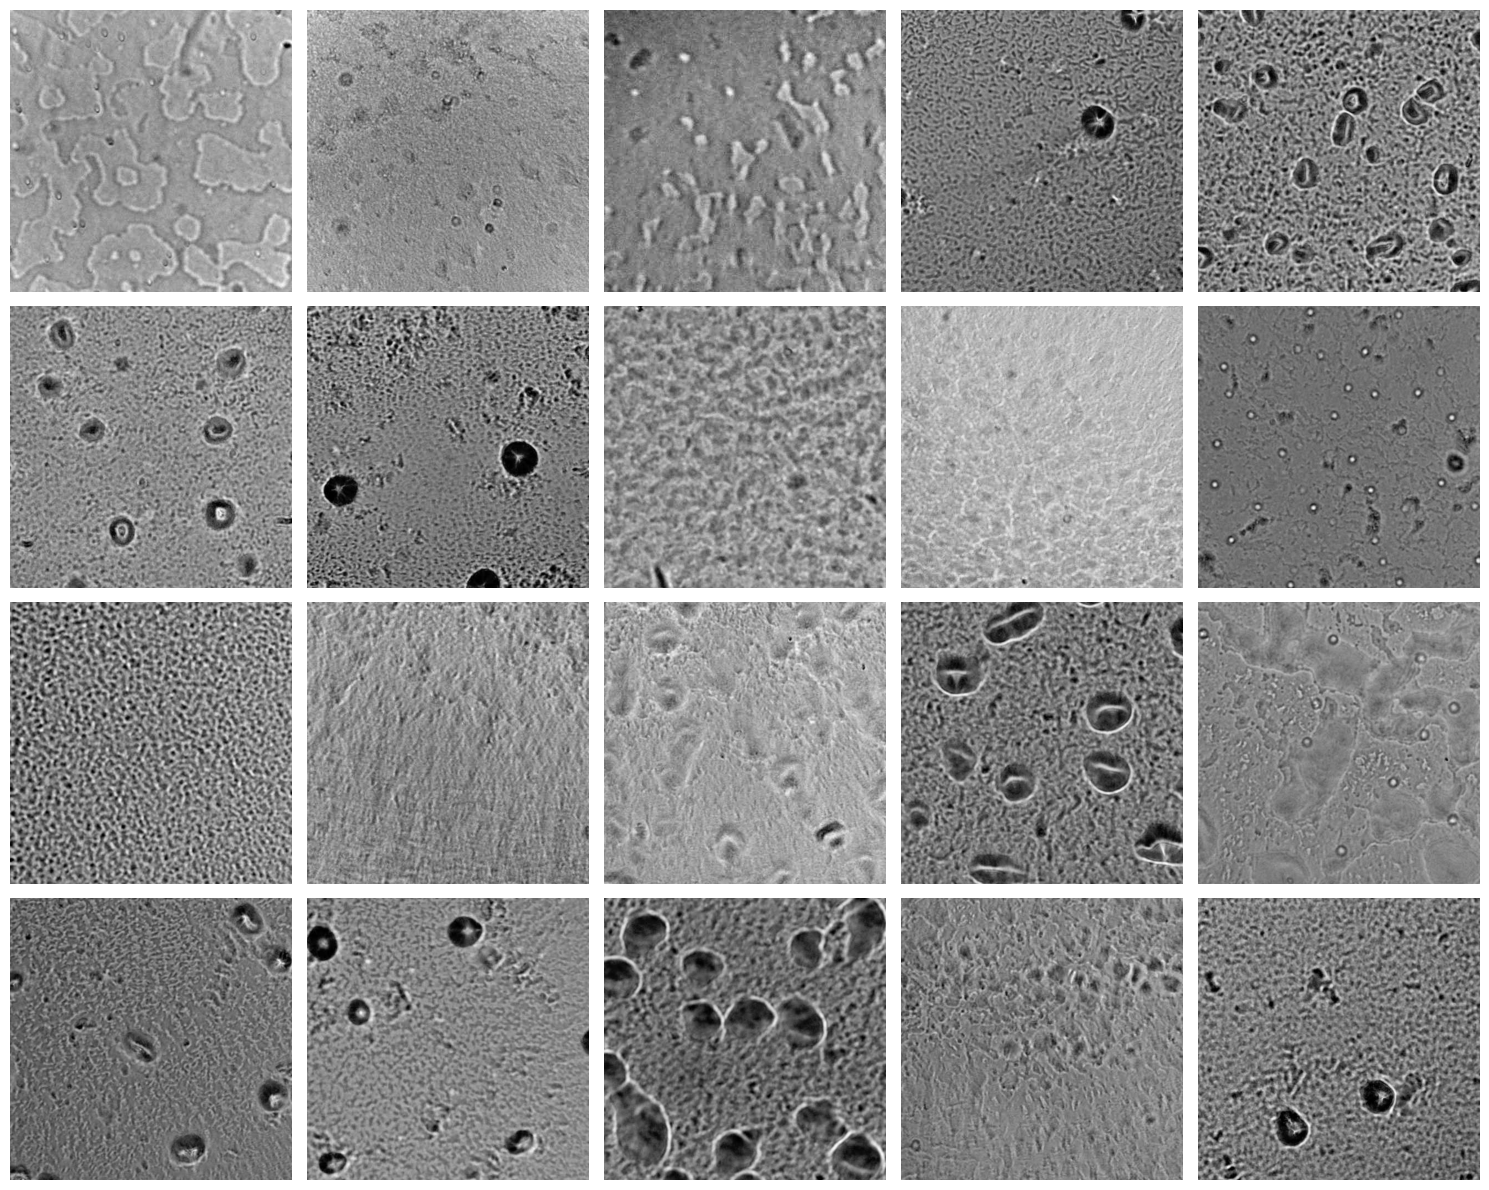

,img_name,label,Category
0,CS_67_6206_1%agar_Run0233/Scope53/Run0233_scop...,11,Test
1,CS_67_6206_1%agar_Run0233/Scope53/Run0233_scop...,11,Test
2,CS_67_6206_1%agar_Run0233/Scope53/Run0233_scop...,11,Test
3,CS_67_6206_1%agar_Run0233/Scope53/Run0233_scop...,3,Test
4,CS_67_6206_1%agar_Run0233/Scope53/Run0233_scop...,11,Test
...,...,...,...
1348810,CS4_81_5257_1%agar_Run0526/Scope27/Run0526_sco...,12,Training
1348811,CS4_81_5257_1%agar_Run0526/Scope27/Run0526_sco...,12,Training
1348812,CS4_81_5257_1%agar_Run0526/Scope27/Run0526_sco...,12,Training
1348813,CS4_81_5257_1%agar_Run0526/Scope27/Run0526_sco...,11,Training


In [15]:
import os

import cv2
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

IMG_DIR = "/home/xavier/Documents/dataset/Welch/trainingset2/trainingset2"
CLASSIFIER = "/home/xavier/Documents/dataset/Welch/classification-v2024/classification_models/240430-001/movie_classification"
n_samples = 20
final_df = pd.read_csv(f"{CLASSIFIER}/classified_images.csv")

# print(f"We have {len(final_df[''])} images")
sampled_images = final_df.sample(n_samples, random_state=42)

# Create a matplotlib figure to plot the images
fig, axs = plt.subplots(4, 5, figsize=(15, 12))

for i, (_, row) in enumerate(sampled_images.iterrows()):
    img_path = os.path.join(IMG_DIR, row['img_name'])
    img = Image.open(img_path)
    width, height = img.size
    # Calculate center crop coordinates
    left = (width - 512) / 2
    top = (height - 512) / 2
    right = (width + 512) / 2
    bottom = (height + 512) / 2
    # Crop the image
    img_cropped = img.crop((left, top, right, bottom))
    # Plot the image
    axs[i // 5, i % 5].imshow(img_cropped, cmap='gray')
    axs[i // 5, i % 5].axis('off')

plt.tight_layout()
plt.show()
final_df

## Visualize stratified sampled images

In [36]:
import os
import cv2
import random
import pickle as pkl
import numpy as np

TRAINING_DICT_PATH = "/home/xavier/Documents/dataset/Welch/classification-v2024/classification_models/240430-001/movie_classification/training_dict.pkl"
IMG_DIR = "/home/xavier/Documents/dataset/Welch/trainingset2/trainingset2"
BATCH_SIZE = 15
CROP_SIZE = 512
RANDOM_SEED = 42

random.seed(RANDOM_SEED)
training_dict = pkl.load(open(TRAINING_DICT_PATH, 'rb'))
shuffled_dict = {k: random.sample(v, len(v)) for k, v in training_dict.items()}

# Prepare to collect cropped images
images = []
label_cycle = list(shuffled_dict.keys())
idx = 0

while len(images) < BATCH_SIZE:
    label = label_cycle[idx % len(label_cycle)]
    if shuffled_dict[label]:
        img_rel_path = shuffled_dict[label].pop()
        img_path = os.path.join(IMG_DIR, img_rel_path)
        img = cv2.imread(img_path)
        if img is None:
            idx += 1
            continue

        h, w = img.shape[:2]
        ch, cw = h // 2, w // 2
        cropped = img[ch - CROP_SIZE // 2: ch + CROP_SIZE // 2,
                  cw - CROP_SIZE // 2: cw + CROP_SIZE // 2]
        if cropped.shape[:2] == (CROP_SIZE, CROP_SIZE):
            images.append(cropped)
    idx += 1

# Tile into a single image (4x4 grid)
grid_rows, grid_cols = 3, 5
tiled = np.zeros((grid_rows * CROP_SIZE, grid_cols * CROP_SIZE, 3), dtype=np.uint8)

for i, img in enumerate(images):
    row = i // grid_cols
    col = i % grid_cols
    tiled[row * CROP_SIZE:(row + 1) * CROP_SIZE,
    col * CROP_SIZE:(col + 1) * CROP_SIZE] = img

# Save
os.makedirs(OUT_DIR, exist_ok=True)
cv2.imwrite(os.path.join(OUT_DIR, "batch_tile_1B.tiff"), tiled)
cv2.imwrite(os.path.join(OUT_DIR, "batch_tile_1B.png"), tiled)

print("Saved tiled batch image as Supplementary Figure 1B.")
# ---- Fully random sample (no label balancing) ---- #
# Flatten all image paths from training_dict
all_image_paths = sum(training_dict.values(), [])
random.seed(RANDOM_SEED + 1)  # Different seed for full randomness
random.shuffle(all_image_paths)

random_images = []
for img_rel_path in all_image_paths:
    img_path = os.path.join(IMG_DIR, img_rel_path)
    img = cv2.imread(img_path)
    if img is None:
        continue

    h, w = img.shape[:2]
    ch, cw = h // 2, w // 2
    cropped = img[ch - CROP_SIZE // 2: ch + CROP_SIZE // 2,
              cw - CROP_SIZE // 2: cw + CROP_SIZE // 2]

    if cropped.shape[:2] == (CROP_SIZE, CROP_SIZE):
        random_images.append(cropped)
    if len(random_images) == BATCH_SIZE:
        break

# Tile the random sample into a 4×4 image
tiled_random = np.zeros((grid_rows * CROP_SIZE, grid_cols * CROP_SIZE, 3), dtype=np.uint8)

for i, img in enumerate(random_images):
    row = i // grid_cols
    col = i % grid_cols
    tiled_random[row * CROP_SIZE:(row + 1) * CROP_SIZE,
    col * CROP_SIZE:(col + 1) * CROP_SIZE] = img

# Save
cv2.imwrite(os.path.join(OUT_DIR, "batch_tile_1B_random.tiff"), tiled_random)
cv2.imwrite(os.path.join(OUT_DIR, "batch_tile_1B_random.png"), tiled_random)

print("Saved fully random sampled image grid for comparison.")


Saved tiled batch image as Supplementary Figure 1B.
Saved fully random sampled image grid for comparison.


## Visualize human labelled end-frame images

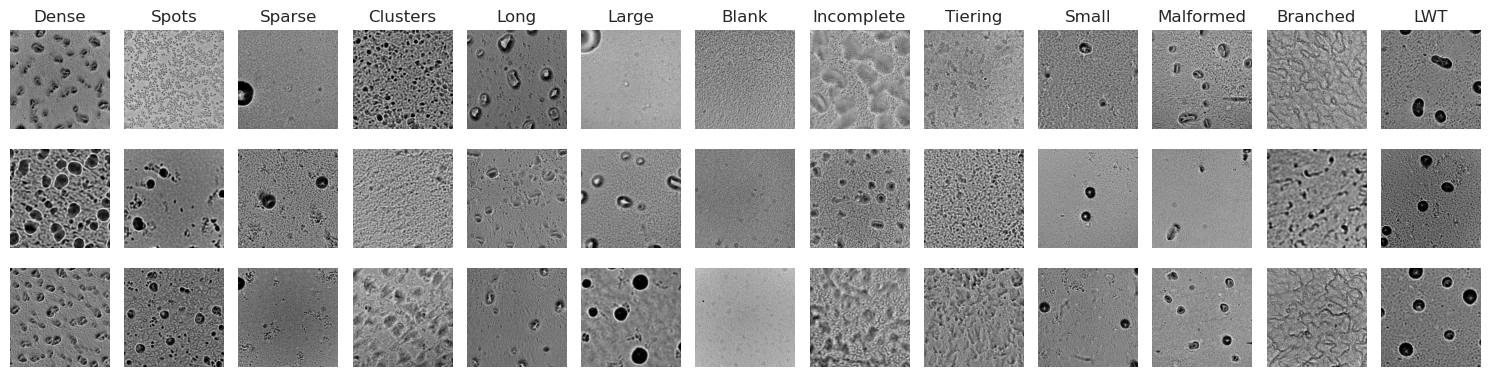

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

IMG_DIR = "/home/xavier/Documents/dataset/Welch/classification-v2024/selected_images"
OUT_DIR = "/home/xavier/Documents/dataset/Welch/classification-v2024"
n_samples = 3

name_df = []
phenotype_dict = {}
'''Build dataset'''
for phenotype in os.listdir(IMG_DIR):
    phenotype_dict[phenotype] = os.listdir(os.path.join(IMG_DIR, phenotype))
    for image_name in os.listdir(os.path.join(IMG_DIR, phenotype)):
        run_id = int(image_name[3:7])
        scope_id = int(image_name[13:14]) if image_name[14] == "-" else int(image_name[13:15])
        frame_id = int(image_name[-8:-4])
        if frame_id != 1081 and frame_id != 1241:
            name_df.append((run_id, scope_id, phenotype, image_name))

name_df = pd.DataFrame(name_df, columns=['run_id', 'scope_id', 'phenotype', 'name'])


# Function to crop image to 512x512 around the center
def crop_center(img):
    width, height = img.size
    left = (width - 512) / 2
    top = (height - 512) / 2
    right = (width + 512) / 2
    bottom = (height + 512) / 2
    return img.crop((left, top, right, bottom))


# Create a figure to plot the images
fig, axs = plt.subplots(n_samples, len(name_df['phenotype'].unique()), figsize=(15, 4))

# Iterate over unique phenotypes
for i, phenotype in enumerate(name_df['phenotype'].unique()):
    # Filter images for the current phenotype
    phenotype_images = name_df[name_df['phenotype'] == phenotype].sample(n=n_samples, random_state=42)
    # Iterate over sampled images for the current phenotype
    for j, (_, row) in enumerate(phenotype_images.iterrows()):
        img_path = os.path.join(IMG_DIR, phenotype, row['name'])
        img = Image.open(img_path)
        img_cropped = crop_center(img)
        axs[j, i].imshow(img_cropped, cmap='gray')
        if j == 0:
            axs[j, i].set_title(phenotype)
        axs[j, i].axis('off')

plt.tight_layout()
plt.show()

# Visualize Shimkets dataset

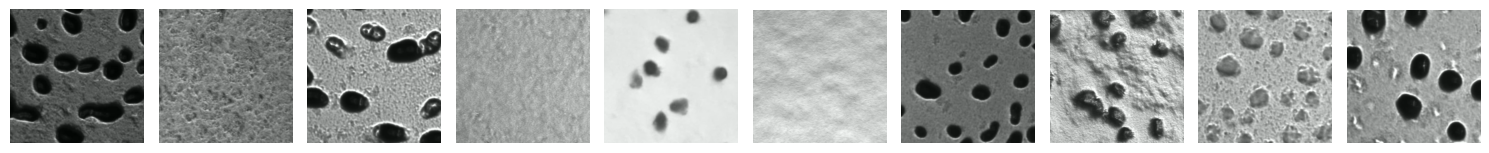

In [8]:
import os
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tifffile
import cv2

MOV_DIR = "/media/xavier/Storage/feature_extraction/movie/movies"
n_samples = 10

tasks = []
for root, dirs, files in os.walk(MOV_DIR):
    for file in files:
        if file.lower().endswith(('.mp4', '.avi', '.mov')):
            path = os.path.join(root, file)
            # Extract the 'STRAIN' and 'idx' from the directory name
            dir_name = os.path.basename(root)
            strain = '_'.join(dir_name.split('_')[:-1])
            tasks.append({'path': path, 'strain': strain})

tasks_df = pd.DataFrame(tasks)


# Function to crop image to 512x512 around the center
def crop_center(img, resize_by=1.15, resolution=512):
    width, height = img.shape[:2]
    img = cv2.resize(img, (int(height * resize_by), int(width * resize_by)), interpolation=cv2.INTER_AREA)
    img_center = [img.shape[0] // 2, img.shape[1] // 2]
    return img[img_center[0] - resolution // 2:img_center[0] + resolution // 2,
           img_center[1] - resolution // 2:img_center[1] + resolution // 2]


# Create a figure to plot the images
fig, axs = plt.subplots(1, n_samples, figsize=(15, 4))

tasks_df = tasks_df.sample(frac=1).reset_index(drop=True)
count = 0
for idx, video_info in tasks_df.iterrows():
    cap = cv2.VideoCapture(video_info['path'])
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.set(cv2.CAP_PROP_POS_FRAMES, total_frames - 1)
    ret, last_frame = cap.read()
    if last_frame.shape != (1200, 1600, 3):
        continue
    last_frame = np.array(last_frame)
    last_frame = crop_center(last_frame)
    axs[count].imshow(last_frame, cmap='gray')
    axs[count].axis('off')
    count += 1
    if count == n_samples:
        break
plt.tight_layout()
plt.show()

# Compare DK1622 in two datasets

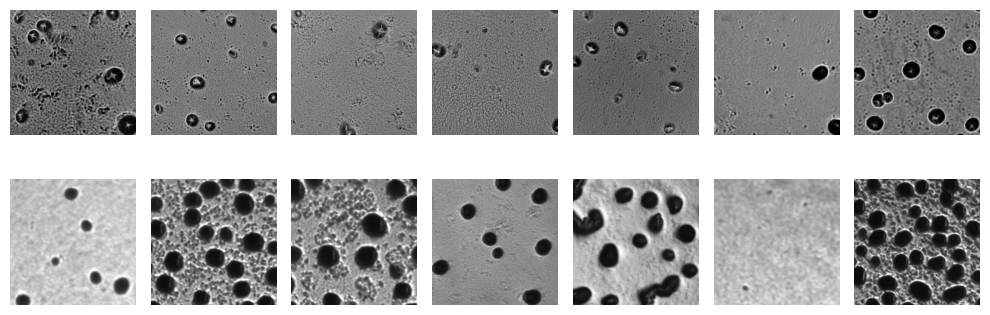

In [70]:
final_df['strain'] = final_df['img_name'].apply(lambda x: x.split('_')[2])
final_df['frame'] = final_df['img_name'].apply(lambda x: int(x[-8:-4]))
filtered_final_df = final_df[(final_df['strain'] == '1622') & (final_df['frame'] == 1441)]
filtered_tasks_df = tasks_df[tasks_df['strain'] == 'DK1622']
n_samples = min(10, len(filtered_final_df), len(filtered_tasks_df))

samples1 = filtered_final_df['img_name'].sample(n_samples, random_state=42)
samples2 = filtered_tasks_df['path'].sample(n_samples, random_state=42)


def crop_center(filename, resize_by=1.15, resolution=512):
    if filename.endswith(('.mp4', '.avi', '.mov')):
        cap = cv2.VideoCapture(filename)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.set(cv2.CAP_PROP_POS_FRAMES, total_frames - 1)
        ret, last_frame = cap.read()
        last_frame = np.array(last_frame)
    else:
        last_frame = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    width, height = last_frame.shape[:2]
    last_frame = cv2.resize(last_frame, (int(height * resize_by), int(width * resize_by)), interpolation=cv2.INTER_AREA)
    img_center = [last_frame.shape[0] // 2, last_frame.shape[1] // 2]
    return last_frame[img_center[0] - resolution // 2:img_center[0] + resolution // 2,
           img_center[1] - resolution // 2:img_center[1] + resolution // 2]


fig, axs = plt.subplots(2, n_samples, figsize=(10, 4))

for idx, (img_name, mov_name) in enumerate(zip(samples1, samples2)):
    welch_img = crop_center(os.path.join(IMG_DIR, img_name), resize_by=1)
    shimkets_img = crop_center(mov_name, resize_by=1.15)
    axs[0, idx].imshow(welch_img, cmap='gray')
    axs[0, idx].axis('off')
    axs[1, idx].imshow(shimkets_img, cmap='gray')
    axs[1, idx].axis('off')

plt.tight_layout()
plt.show()

In [62]:
samples1

3520       CS1_22_1622_1%agar_Run0261/Scope10/Run0261_sco...
38916      CS3_66_1622_1%agar_Run0432/Scope08/Run0432_sco...
1247747    CS1_22_1622_1%agar_Run0261/Scope11/Run0261_sco...
71144      CS5_04_1622_1%agar_Run0582/Scope09/Run0582_sco...
188751     CS3_66_1622_1%agar_Run0432/Scope07/Run0432_sco...
Name: img_name, dtype: object